<a href="https://colab.research.google.com/github/kevinhoffmanglyde/oxfordgenaigroup2/blob/main/Group2EndtoEnd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Section Overview:#
This section is a model comparision for selection of the models.
To use the selected model in the project for the business, we need to be able to feed in a full dataset, retrain the model based on the new data, and create predictions based on the fresh data and newly trained model.
This section separates the Training and Test data for checking accuracy and loss in order to select the better model for the job.



#Mount the Google Drive

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Authenticate

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


#Get the data

In [3]:
df = pd.read_csv('gdrive/MyDrive/Complete_Sales_Data.csv')

#Check the data is there

In [4]:
df.head()

,Country,Store ID,Product Category,Product ID,Inflation Rate,GDP Growth Rate,Date of Sale,Price Sold,Units Sold,Year-Month
0,France,7,Mens,1,10.6,3.12,2023-01-01,34.5,13,2023-01
1,France,8,Mens,1,10.6,3.12,2023-01-01,34.5,29,2023-01
2,France,9,Mens,1,10.6,3.12,2023-01-01,34.5,23,2023-01
3,France,7,Mens,1,10.6,3.12,2023-01-02,34.5,12,2023-01
4,France,8,Mens,1,10.6,3.12,2023-01-02,34.5,30,2023-01


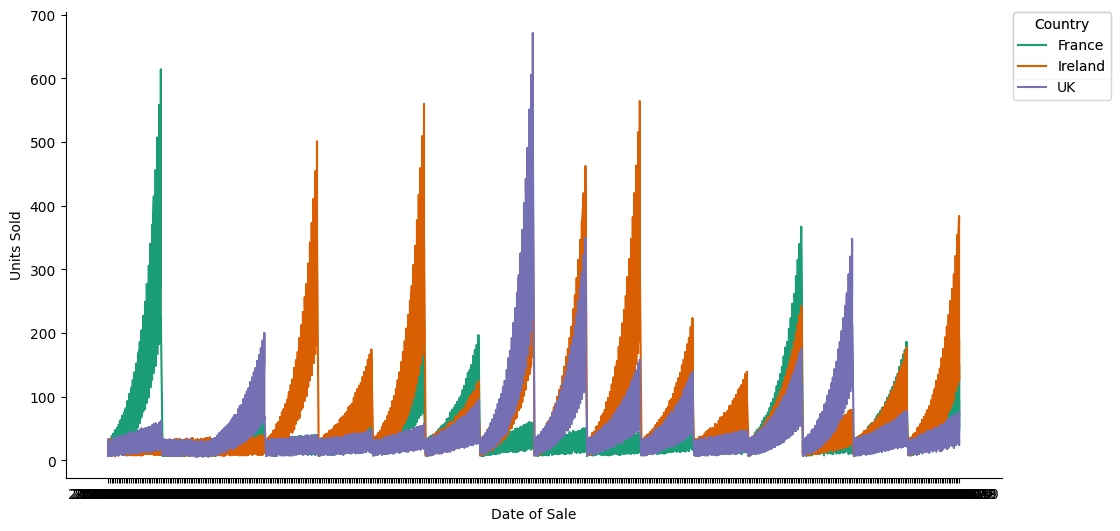

In [5]:
# @title Date of Sale vs Units Sold

from matplotlib import pyplot as plt
import seaborn as sn
def _plot_series(series, series_name, series_index=0):
  palette = list(sn.palettes.mpl_palette('Dark2'))
  xs = series['Date of Sale']
  ys = series['Units Sold']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Date of Sale', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Country')):
  _plot_series(series, series_name, i)
  fig.legend(title='Country', bbox_to_anchor=(1, 1), loc='upper left')
sn.despine(fig=fig, ax=ax)
plt.xlabel('Date of Sale')
_ = plt.ylabel('Units Sold')

<ipython-input-6-7bbc60e62bbc>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sn.violinplot(df, x='Units Sold', y='Country', inner='box', palette='Dark2')


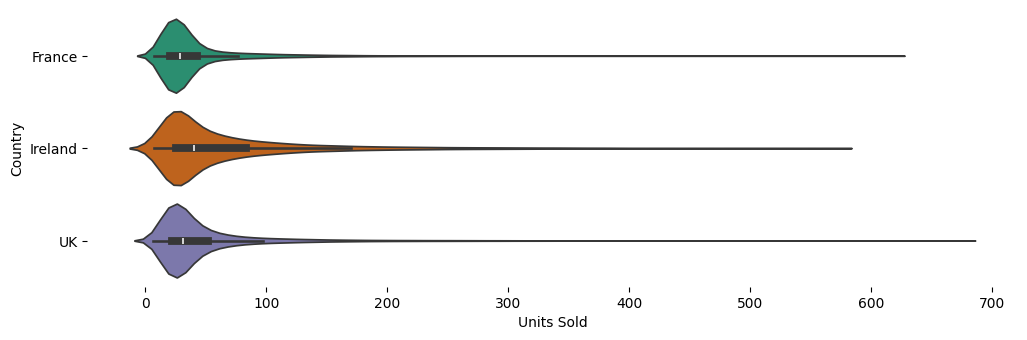

In [6]:
# @title Country vs Units Sold

figsize = (12, 1.2 * len(df['Country'].unique()))
plt.figure(figsize=figsize)
sn.violinplot(df, x='Units Sold', y='Country', inner='box', palette='Dark2')
sn.despine(top=True, right=True, bottom=True, left=True)

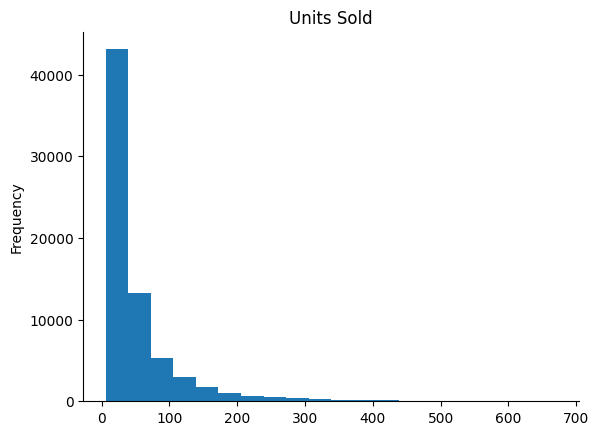

In [7]:
# @title Units Sold

df['Units Sold'].plot(kind='hist', bins=20, title='Units Sold')
plt.gca().spines[['top', 'right',]].set_visible(False)

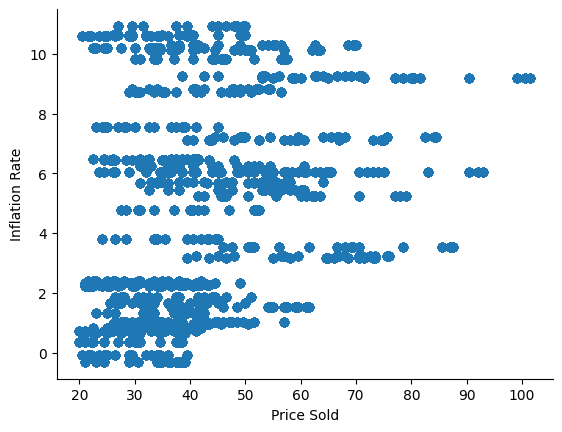

In [8]:
# @title Price Sold vs Inflation Rate
df.plot(kind='scatter', x='Price Sold', y='Inflation Rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

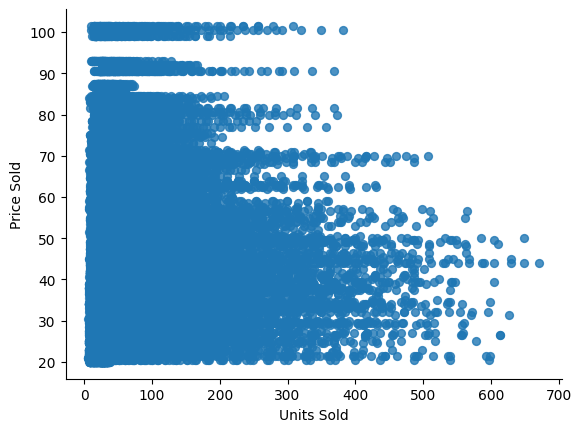

In [9]:
# @title Units Sold vs Price Sold

df.plot(kind='scatter', x='Units Sold', y='Price Sold', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

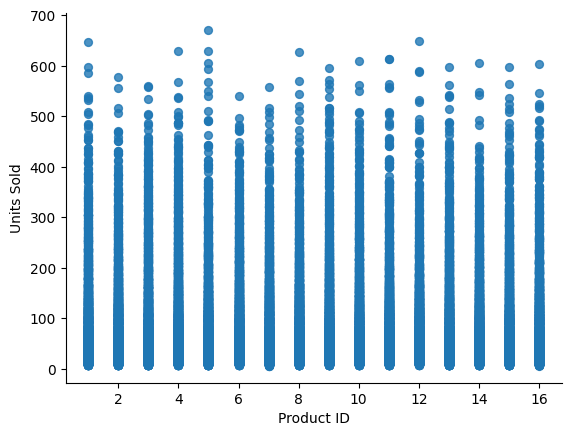

In [10]:
df.plot(kind='scatter', x='Product ID', y='Units Sold', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

##Now examine the data
The biggest worry is that once we get to the testing of the model, using the synthetic data, we may be trying to map the model based on the training data to data that is completely random.
The data we have is for all of 2023 and up to the end of April 2024.  The method for creating the synthetic data is included in a document, but in short - the Price Sold and Units Sold are created by tracking the Inflation Rate.  Then the units sold are slightly randomised to imitate freedom of choice.

In [11]:
import pandas as pd
import numpy as np
import datetime
datetosplit = 202403
reference_date = datetime.date(1970, 1, 1)
# train_test_split is used to easily divide data into training and testing sets.
from sklearn.model_selection import train_test_split
# LinearRegression is the model we'll be using from scikit-learn.
from sklearn.linear_model import LinearRegression
# mean_absolute_error and mean_squared_error are metrics to evaluate our model.
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# matplotlib.pyplot is used for plotting graphs.
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

The store ID is unique, and there are 3 stores per country.
The price per product should match for each store in the country on a given date.

In [12]:
df = df.sort_values(["Date of Sale"], ascending = (True)) # order the data by year, month, day in ascending order.
df.head() # check the data again by viewing the first 5 rows

,Country,Store ID,Product Category,Product ID,Inflation Rate,GDP Growth Rate,Date of Sale,Price Sold,Units Sold,Year-Month
0,France,7,Mens,1,10.60,3.12,2023-01-01,34.5,13,2023-01
51031,UK,5,Mens,4,2.34,3.48,2023-01-01,35.0,27,2023-01
51030,UK,4,Mens,4,2.34,3.48,2023-01-01,35.0,32,2023-01
5832,France,7,Mens,5,10.60,3.12,2023-01-01,21.5,30,2023-01
5833,France,8,Mens,5,10.60,3.12,2023-01-01,21.5,25,2023-01


A little surprised by the Max Units Sold.

In [13]:
df.describe()

,Store ID,Product ID,Inflation Rate,GDP Growth Rate,Price Sold,Units Sold
count,69984.000000,69984.000000,69984.000000,69984.000000,69984.000000,69984.000000
mean,5.000000,8.500000,4.860645,1.140075,42.378408,54.360225
std,2.582007,4.609805,3.464731,1.724644,15.011343,62.380080
min,1.000000,1.000000,-0.310000,-1.870000,20.000000,6.000000
25%,3.000000,4.750000,1.650000,-0.110000,31.000000,22.000000
50%,5.000000,8.500000,5.250000,0.970000,39.500000,32.000000
75%,7.000000,12.250000,7.210000,2.820000,50.500000,58.000000
max,9.000000,16.000000,10.930000,3.970000,101.500000,671.000000


In [14]:
print(df['Units Sold'])

0         13
51031     27
51030     32
5832      30
5833      25
        ... 
45196    303
45195    205
43739    292
46655    189
69983     71
Name: Units Sold, Length: 69984, dtype: int64


In [15]:
df.isnull().sum()

Country             0
Store ID            0
Product Category    0
Product ID          0
Inflation Rate      0
GDP Growth Rate     0
Date of Sale        0
Price Sold          0
Units Sold          0
Year-Month          0
dtype: int64

Looks like no Nulls, which is expected for our synthetic data.

In [16]:
df['Units Sold'].isna().sum()

0

Tidy up some of the data columns just in case.
Doing a drop method rather than inplace replacement.

In [17]:
#clean up any nulls that might come through in real data
df = df.dropna(subset=['Store ID', 'Product ID', 'Units Sold', 'Date of Sale', 'Price Sold'])

##Check out the distribution of the data

In [18]:
unique_store = df['Store ID'].nunique()
unique_product = df['Product ID'].nunique()
unique_product_cat = df['Product Category'].nunique()
unique_country = df['Country'].nunique()
unique_pricesold = df['Price Sold'].nunique()


print("Distinct Stores:", unique_store)
print("Distinct Products:", unique_product)
print("Distinct Product Categories:", unique_product_cat)
print("Distinct Countries:", unique_country)
print("Distinct Prices:", unique_pricesold)

Distinct Stores: 9
Distinct Products: 16
Distinct Product Categories: 2
Distinct Countries: 3
Distinct Prices: 132


Data above looks OK.
Stores, Products, Categories and Countries look like the specifications in the data.
Prices have a different value for each country and each product for each month.  642 is a good ballpark.

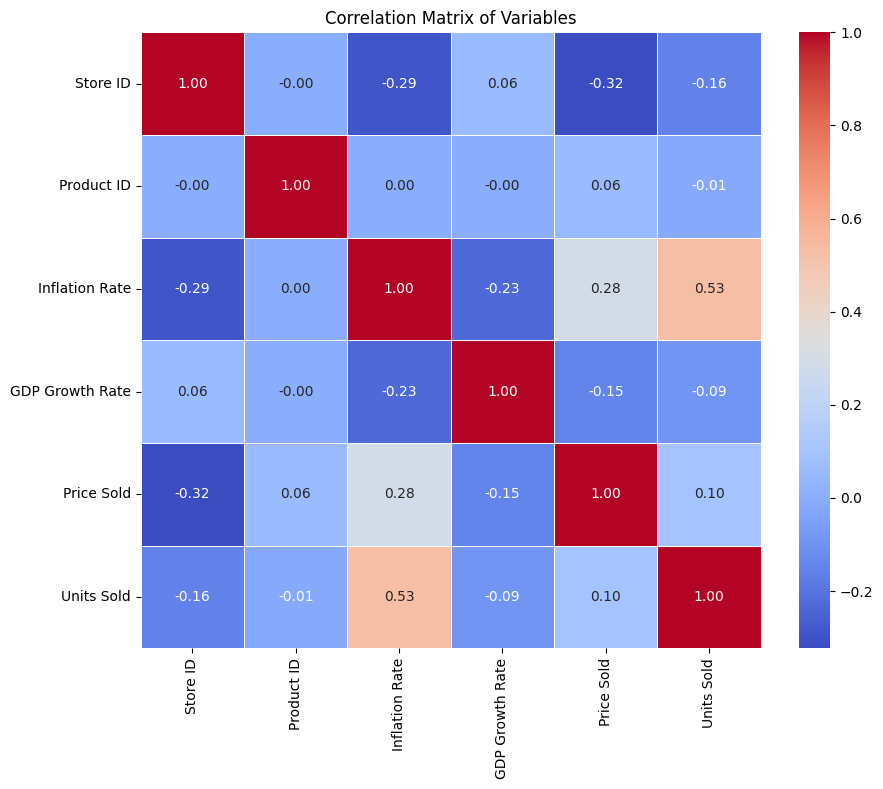

In [19]:
# Calculating the correlation matrix
correlation_matrix = df.corr(numeric_only=True)
#numeric_only is a new variable for the correlation matrix.
#If we want to include Country, we would have to include one-hot-encoding on Country because it is a string and will not fit in a correlation matrix.
# Initializes a new figure for plotting with a specified size to ensure the heatmap is large enough to read.
plt.figure(figsize=(10, 8))

# Creates a heatmap to visualize the correlation matrix.
# - annot=True displays the correlation coefficient values inside the squares.
# - cmap='coolwarm' chooses a color map that visually represents positive (warm) and negative (cool) correlations.
# - fmt=".2f" formats the annotation strings to display only two decimal places.
# - linewidths=.5 adds lines between squares to separate them visually.
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Sets the title of the heatmap for clarity.
plt.title('Correlation Matrix of Variables')

# Displays the plot. Without this, the figure would not be shown in a notebook.
plt.show()

Inflation rate and store ID have the biggest corelation to Units Sold.  That's expected.  Though Inflation rate is supposed to influence Price Sold much more strongly.

In [21]:
df['Date of Sale'] = pd.to_datetime(df['Date of Sale'])
min_sale_date = df['Date of Sale'].min()
max_sale_date = df['Date of Sale'].max()

print("Minimum date:", min_sale_date)
print("Maximum date:", max_sale_date)

Minimum date: 2023-01-01 00:00:00
Maximum date: 2024-04-30 00:00:00


Date range as expected.

#Date issues##
Since we are trying to predict future demand, this suggests that when we divide the Training and Test data, we need to do this on a date basis.  Including dates in the training set that should appear in the test set is not desired.  When using this on real data in production, the future dates will all be empty.

So, selecting out test and train data set should be on dates rather than simply a percentage of the dataset.  I have used most of the data for training, but left out 3 months of the 15 as test data.

Once the data split is completed, I dropped the Date of Sale and aggregated the data to the month.

#Split the data into Past and "Future"

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np


Convert to a DateTime - this is used to extract year and month values

In [23]:
df['Date of Sale'] = pd.to_datetime(df['Date of Sale'])

In [24]:
print(df['Date of Sale'])

0       2023-01-01
51031   2023-01-01
51030   2023-01-01
5832    2023-01-01
5833    2023-01-01
           ...    
45196   2024-04-30
45195   2024-04-30
43739   2024-04-30
46655   2024-04-30
69983   2024-04-30
Name: Date of Sale, Length: 69984, dtype: datetime64[ns]


#Set the monthly values
Price Sold
Inflation Rate
Units Sold
###Ignoring GDP Growth Rate as that is going to be dropped

In [25]:
df['YearMonth'] = df['Date of Sale'].dt.year*100+df['Date of Sale'].dt.month
X = df[['Store ID', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold', 'Product ID', 'YearMonth', 'Product Category']]
dfa = df[['Store ID', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold', 'Product ID', 'YearMonth', 'Units Sold', 'Product Category', 'Country']]
# Assuming dfa is your original DataFrame
units_sold_aggregate = dfa.groupby([
    'Store ID', 'GDP Growth Rate', 'Price Sold', 'Product ID',
    'YearMonth', 'Product Category', 'Country', 'Inflation Rate'
])['Units Sold'].sum().reset_index()
units_sold_aggregate.rename(columns={'Units Sold': 'Units Sold Aggregate'}, inplace=True)

price_sold_average = dfa.groupby([
    'Store ID', 'GDP Growth Rate', 'Product ID',
    'YearMonth', 'Product Category', 'Country', 'Inflation Rate'
])['Price Sold'].mean().reset_index()
price_sold_average.rename(columns={'Price Sold': 'Average Price Sold'}, inplace=True)

#inflation rate is not necessary as it is the same for each monthly aggregate.

result = pd.merge(units_sold_aggregate, price_sold_average, on=[
    'Store ID', 'GDP Growth Rate', 'Product ID',
    'YearMonth', 'Product Category', 'Country', 'Inflation Rate'
], how='inner')



In [26]:
print(result)

      Store ID  GDP Growth Rate  Price Sold  Product ID  YearMonth  \
0            1            -1.64        30.0           5     202308   
1            1            -1.64        31.0           7     202308   
2            1            -1.64        33.5           2     202308   
3            1            -1.64        33.5           6     202308   
4            1            -1.64        34.0           3     202308   
...        ...              ...         ...         ...        ...   
2299         9             3.96        34.0           7     202304   
2300         9             3.96        35.0           3     202304   
2301         9             3.96        35.5           1     202304   
2302         9             3.96        37.0          10     202304   
2303         9             3.96        41.0          12     202304   

     Product Category  Country  Inflation Rate  Units Sold Aggregate  \
0                Mens  Ireland            9.81                  2463   
1              

#Drop the columns we won't be using and rename the aggregates

In [27]:
print(result)

#result = result.drop(columns='Units Sold')
result = result.drop(columns='Price Sold')
result = result.drop(columns='GDP Growth Rate')
result = result.drop(columns='Product Category')
result = result.drop(columns='Country')
result.rename(columns={'Units Sold Aggregate': 'Units Sold'}, inplace=True)
result.rename(columns={'Average Price Sold': 'Price Sold'}, inplace=True)
#result.rename(columns={'Min Inflation Rate': 'Inflation Rate'}, inplace=True)

      Store ID  GDP Growth Rate  Price Sold  Product ID  YearMonth  \
0            1            -1.64        30.0           5     202308   
1            1            -1.64        31.0           7     202308   
2            1            -1.64        33.5           2     202308   
3            1            -1.64        33.5           6     202308   
4            1            -1.64        34.0           3     202308   
...        ...              ...         ...         ...        ...   
2299         9             3.96        34.0           7     202304   
2300         9             3.96        35.0           3     202304   
2301         9             3.96        35.5           1     202304   
2302         9             3.96        37.0          10     202304   
2303         9             3.96        41.0          12     202304   

     Product Category  Country  Inflation Rate  Units Sold Aggregate  \
0                Mens  Ireland            9.81                  2463   
1              

In [28]:
print(result)
Y = result['Units Sold']
X =  result.drop(columns='Units Sold')

      Store ID  Product ID  YearMonth  Inflation Rate  Units Sold  Price Sold
0            1           5     202308            9.81        2463        30.0
1            1           7     202308            9.81        1768        31.0
2            1           2     202308            9.81        4550        33.5
3            1           6     202308            9.81        2791        33.5
4            1           3     202308            9.81        4375        34.0
...        ...         ...        ...             ...         ...         ...
2299         9           7     202304            0.74         685        34.0
2300         9           3     202304            0.74         675        35.0
2301         9           1     202304            0.74         995        35.5
2302         9          10     202304            0.74         664        37.0
2303         9          12     202304            0.74         834        41.0

[2304 rows x 6 columns]


In [29]:
X.describe()

,Store ID,Product ID,YearMonth,Inflation Rate,Price Sold
count,2304.000000,2304.000000,2304.000000,2304.000000,2304.000000
mean,5.000000,8.500000,202330.500000,4.838542,42.366536
std,2.582549,4.610773,41.689379,3.477477,15.035913
min,1.000000,1.000000,202301.000000,-0.310000,20.000000
25%,3.000000,4.750000,202304.750000,1.620000,31.000000
50%,5.000000,8.500000,202308.500000,5.005000,39.500000
75%,7.000000,12.250000,202334.250000,7.297500,50.500000
max,9.000000,16.000000,202404.000000,10.930000,101.500000


#Set the datesplit value
In a productionised system this would have to be dynamic

In [30]:
#split_date = pd.to_datetime(datetosplit)
# Data before the split date
datetosplit = 202401
X_Train = X[X['YearMonth'] <= datetosplit]

print("Data before the split date:")
print(X_Train)



Data before the split date:
      Store ID  Product ID  YearMonth  Inflation Rate  Price Sold
0            1           5     202308            9.81        30.0
1            1           7     202308            9.81        31.0
2            1           2     202308            9.81        33.5
3            1           6     202308            9.81        33.5
4            1           3     202308            9.81        34.0
...        ...         ...        ...             ...         ...
2299         9           7     202304            0.74        34.0
2300         9           3     202304            0.74        35.0
2301         9           1     202304            0.74        35.5
2302         9          10     202304            0.74        37.0
2303         9          12     202304            0.74        41.0

[1872 rows x 5 columns]


In [31]:
print(X[X['YearMonth'] > datetosplit])

      Store ID  Product ID  YearMonth  Inflation Rate  Price Sold
144          1           5     202404            9.18        53.0
145          1           7     202404            9.18        55.0
146          1           2     202404            9.18        58.5
147          1           6     202404            9.18        59.0
148          1           3     202404            9.18        60.0
...        ...         ...        ...             ...         ...
2251         9           7     202404            5.70        53.0
2252         9           3     202404            5.70        54.5
2253         9           1     202404            5.70        55.5
2254         9          10     202404            5.70        58.0
2255         9          12     202404            5.70        64.0

[432 rows x 5 columns]


X_Train is set above

In [32]:
X_Test = X[X['YearMonth'] > datetosplit]
Y_Train = Y[result['YearMonth'] <= datetosplit]
Y_Test = Y[result['YearMonth'] > datetosplit]

Y_Test = Y_Test.drop(columns=['YearMonth'])
print("Data on or after the split date:")
print(X_Test)

print("Data before the split date:")
print(Y_Train)

print("Data on or after the split date:")
print(Y_Test)

Data on or after the split date:
      Store ID  Product ID  YearMonth  Inflation Rate  Price Sold
144          1           5     202404            9.18        53.0
145          1           7     202404            9.18        55.0
146          1           2     202404            9.18        58.5
147          1           6     202404            9.18        59.0
148          1           3     202404            9.18        60.0
...        ...         ...        ...             ...         ...
2251         9           7     202404            5.70        53.0
2252         9           3     202404            5.70        54.5
2253         9           1     202404            5.70        55.5
2254         9          10     202404            5.70        58.0
2255         9          12     202404            5.70        64.0

[432 rows x 5 columns]
Data before the split date:
0       2463
1       1768
2       4550
3       2791
4       4375
        ... 
2299     685
2300     675
2301     995
2302  

#Linear Regression model
Try to tune the Lasso alpha automatically, then fit using the best alpha.
Once concern is that the Lasso sensitive to the scale of input features.

In [33]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
# Creating an instance of the LinearRegression model.

lasso_cv = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)
lasso_cv.fit(X_Train, Y_Train)
best_alpha = lasso_cv.alpha_
# Lasso Regression
modelLR = Lasso(alpha=best_alpha)  # Alpha is a hyperparameter for L1 regularization
#modelLR = LinearRegression(alpha=0.1)
# Fitting the model to the training data. This is where the model learns the relationship between features and target.
modelLR.fit(X_Train, Y_Train)


Lasso(alpha=10.0)

In [34]:
# Cross-validating the model
scores = cross_val_score(modelLR, X_Train, Y_Train, cv=3)
print(f"Cross-validated R² scores: {scores}")
print(f"Average R² score: {np.mean(scores)}")

Cross-validated R² scores: [0.67805588 0.70125432 0.73256301]
Average R² score: 0.7039577368063347


In [35]:
# Use the trained model to make predictions on the testing set.
predictionsLR = modelLR.predict(X_Test)

# Evaluating the model's performance by comparing actual values (y_test) vs predicted values (predictions).
# MAE is the mean absolute error, MSE is the mean squared error, and RMSE is the square root of MSE.

# Evaluating the model
mse = mean_squared_error(Y_Test, predictionsLR)
r2 = r2_score(Y_Test, predictionsLR)
print('MAE:', mean_absolute_error(Y_Test, predictionsLR))
print('MSE:', mean_squared_error(Y_Test, predictionsLR))
print('RMSE:', np.sqrt(mean_squared_error(Y_Test, predictionsLR)))
print(f"R² score: {r2}")

MAE: 452.0142866093555
MSE: 308455.9952252749
RMSE: 555.3881482578422
R² score: 0.5679689758226131


In [36]:
X_Test.describe()

,Store ID,Product ID,YearMonth,Inflation Rate,Price Sold
count,432.000000,432.000000,432.000000,432.000000,432.000000
mean,5.000000,8.500000,202403.000000,5.270000,58.062500
std,2.584983,4.615117,0.817443,2.639152,16.436428
min,1.000000,1.000000,202402.000000,1.030000,29.500000
25%,3.000000,4.750000,202402.000000,3.250000,46.000000
50%,5.000000,8.500000,202403.000000,5.700000,56.250000
75%,7.000000,12.250000,202404.000000,6.240000,69.750000
max,9.000000,16.000000,202404.000000,9.270000,101.500000


#Reset the indices and merge the datasets

This is the Actual values.

In [37]:
from datetime import datetime
#X_Test['Date of Sale'] = pd.to_datetime(X_Test[['Year', 'Month', 'Day']])
X_Test.reset_index(drop=True, inplace=True)
Y_Test.reset_index(drop=True, inplace=True)
merged_df = pd.merge(X_Test, Y_Test, left_index=True, right_index=True)
print(merged_df)
merged_df.describe()


     Store ID  Product ID  YearMonth  Inflation Rate  Price Sold  Units Sold
0           1           5     202404            9.18        53.0        1979
1           1           7     202404            9.18        55.0        3680
2           1           2     202404            9.18        58.5        3105
3           1           6     202404            9.18        59.0        3948
4           1           3     202404            9.18        60.0        2097
..        ...         ...        ...             ...         ...         ...
427         9           7     202404            5.70        53.0        1038
428         9           3     202404            5.70        54.5        2247
429         9           1     202404            5.70        55.5        2010
430         9          10     202404            5.70        58.0        1284
431         9          12     202404            5.70        64.0        1518

[432 rows x 6 columns]


,Store ID,Product ID,YearMonth,Inflation Rate,Price Sold,Units Sold
count,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000
mean,5.000000,8.500000,202403.000000,5.270000,58.062500,1563.118056
std,2.584983,4.615117,0.817443,2.639152,16.436428,845.945489
min,1.000000,1.000000,202402.000000,1.030000,29.500000,333.000000
25%,3.000000,4.750000,202402.000000,3.250000,46.000000,913.000000
50%,5.000000,8.500000,202403.000000,5.700000,56.250000,1348.500000
75%,7.000000,12.250000,202404.000000,6.240000,69.750000,2094.750000
max,9.000000,16.000000,202404.000000,9.270000,101.500000,4229.000000


#Create the predictions dataframe

In [38]:
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
print(df_1d)

      Prediction
0    2734.476417
1    2717.153868
2    2716.549807
3    2699.985477
4    2705.305566
..           ...
427  1648.810412
428  1655.042876
429  1656.867625
430  1612.494723
431  1574.508442

[432 rows x 1 columns]


#Merge the the predictions

In [39]:
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
merged_df2 = pd.merge(X_Test, df_1d, left_index=True, right_index=True)

print(merged_df2)

     Store ID  Product ID  YearMonth  Inflation Rate  Price Sold   Prediction
0           1           5     202404            9.18        53.0  2734.476417
1           1           7     202404            9.18        55.0  2717.153868
2           1           2     202404            9.18        58.5  2716.549807
3           1           6     202404            9.18        59.0  2699.985477
4           1           3     202404            9.18        60.0  2705.305566
..        ...         ...        ...             ...         ...          ...
427         9           7     202404            5.70        53.0  1648.810412
428         9           3     202404            5.70        54.5  1655.042876
429         9           1     202404            5.70        55.5  1656.867625
430         9          10     202404            5.70        58.0  1612.494723
431         9          12     202404            5.70        64.0  1574.508442

[432 rows x 6 columns]


#Merge the actuals and predictions

     Store ID  Product ID  YearMonth  Inflation Rate  Price Sold  Units Sold
0           1           5     202404            9.18        53.0        1979
1           1           7     202404            9.18        55.0        3680
2           1           2     202404            9.18        58.5        3105
3           1           6     202404            9.18        59.0        3948
4           1           3     202404            9.18        60.0        2097
..        ...         ...        ...             ...         ...         ...
427         9           7     202404            5.70        53.0        1038
428         9           3     202404            5.70        54.5        2247
429         9           1     202404            5.70        55.5        2010
430         9          10     202404            5.70        58.0        1284
431         9          12     202404            5.70        64.0        1518

[432 rows x 6 columns]


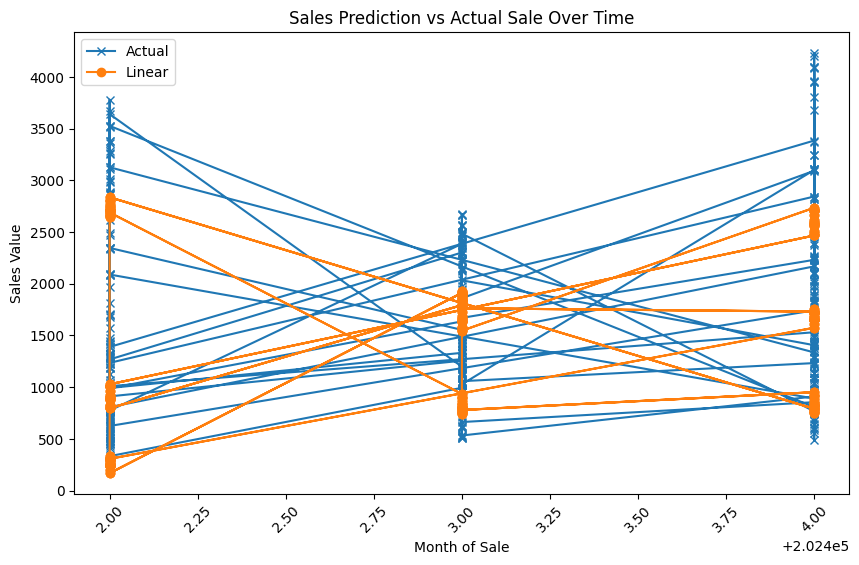

In [40]:
print(merged_df)
#print(filtered_df2)
plt.figure(figsize=(10, 6))  # Set the figure size= modelLR.predict(X_Test)
#print(filtered_df)
plt.plot(merged_df['YearMonth'] , merged_df['Units Sold'], label='Actual', marker='x')  # Plot Sales Prediction
plt.plot(merged_df2['YearMonth'] ,  merged_df2['Prediction'], label='Linear', marker='o')  # Plot Sales Prediction
# Adding titles and labels
plt.title('Sales Prediction vs Actual Sale Over Time')
plt.xlabel('Month of Sale')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)  # Rotate date labels for better readability
#plt.ylim(0, 150)

# Adding legend
plt.legend()

# Show the plot
plt.show()
#X_Test = X_Test.drop(columns=['Date of Sale'])

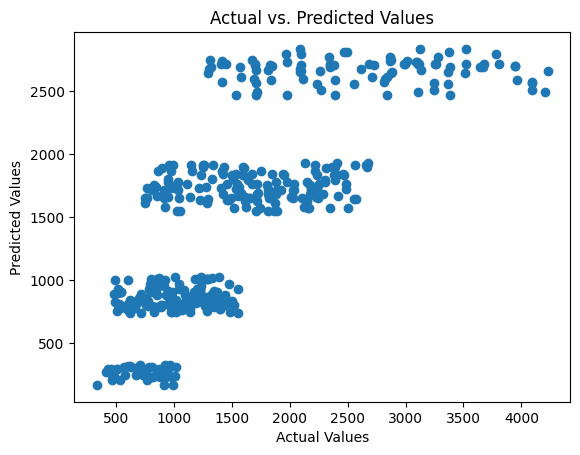

In [41]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsLR)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

#Random Forest
Trying to get the program to tune its own model.
This one takes a significant amount of time.

In [42]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Set up the grid of parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}
# Create a RandomForestRegressor object
rf = RandomForestRegressor(random_state=42)
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_Train, Y_Train)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters:", best_params)
print("Best model:", best_model)

# Make predictions and evaluate the model
from sklearn.metrics import mean_squared_error
# Use the trained model to make predictions on the testing set.
predictionsRF = best_model.predict(X_Test)
mse = mean_squared_error(Y_Test, predictionsRF)
print(f"Mean Squared Error: {mse}")


Fitting 3 folds for each of 324 candidates, totalling 972 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 300}
Best model: RandomForestRegressor(max_depth=10, max_features='auto', min_samples_split=20,
                      n_estimators=300, random_state=42)
Mean Squared Error: 305580.21275303274


In [43]:
# Evaluating the model's performance by comparing actual values (y_test) vs predicted values (predictions).
# MAE is the mean absolute error, MSE is the mean squared error, and RMSE is the square root of MSE.
# Evaluating the model
mseRF = mean_squared_error(Y_Test, predictionsRF)
r2RF = r2_score(Y_Test, predictionsRF)
print('MAE:', mean_absolute_error(Y_Test, predictionsRF))
print('MSE:', mean_squared_error(Y_Test, predictionsRF))
print('RMSE:', np.sqrt(mean_squared_error(Y_Test, predictionsRF)))
print(f"R² score: {r2RF}")

MAE: 428.6021320758423
MSE: 305580.21275303274
RMSE: 552.7931012169315
R² score: 0.5719968672107729


#Scatter plot of the Predictions v Actual

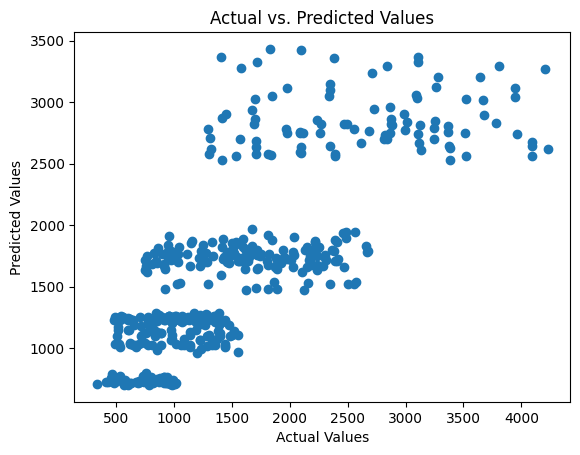

In [44]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsRF)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

#Gradient Booster

In [45]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

#Get the application to try to tune the Gradient Booster
As with Random Forest - scoring on neg_mean_squared_error.  Recommended for Regression models.

In [46]:
# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'subsample': [0.9, 1.0]
}

# Create the model
gbm = GradientBoostingRegressor(random_state=42)

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_Train, Y_Train)

# Best model
best_gbm = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Evaluate the model
predictionsGB = best_gbm.predict(X_Test)
mse = mean_squared_error(Y_Test, predictionsGB)
print(f"Mean Squared Error: {mse}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.9}
Mean Squared Error: 279966.6116539783


In [47]:
# Evaluation
mae = mean_absolute_error(Y_Test, predictionsGB)
mse = mean_squared_error(Y_Test, predictionsGB)
r2 = r2_score(Y_Test,predictionsGB)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

Mean Absolute Error: 416.53528861900253
Mean Squared Error: 279966.6116539783
R² Score: 0.6078719044510568


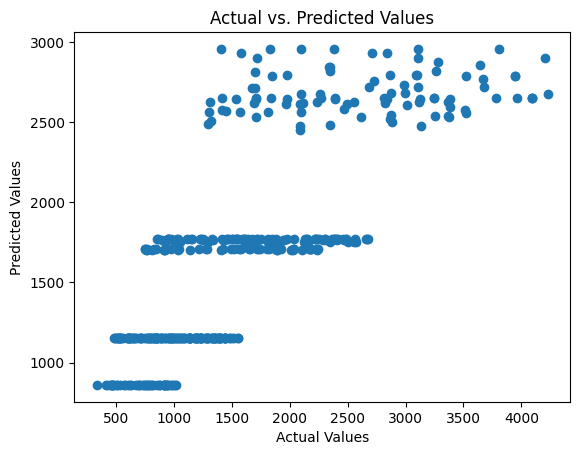

In [48]:
# Plotting actual vs predicted values to visualize how well our model is performing.
plt.scatter(Y_Test, predictionsGB)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs. Predicted Values')  # Graph title
plt.show()  # Display the plot

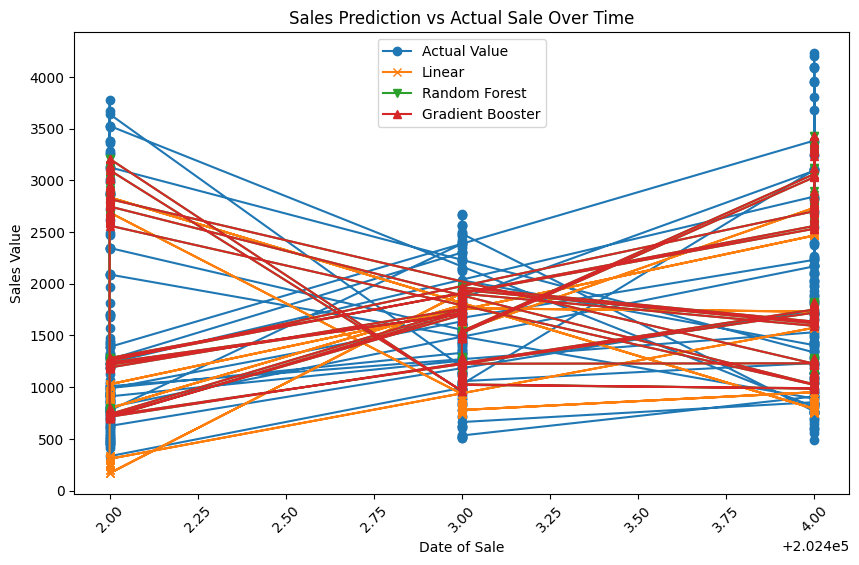

In [49]:
# Create the plot
from datetime import datetime
#X_Test['Date of Sale'] = pd.to_datetime(X_Test[['Year', 'Month', 'Day']])
#print(X_Test['Date of Sale'].head(10))

merged_df = pd.merge(X_Test, Y_Test, left_index=True, right_index=True)
#filtered_df = merged_df[merged_df['Store ID'] == 10100]
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
df_1d2 = pd.DataFrame(predictionsRF, columns=['PredictionRF'])
df_1d3 = pd.DataFrame(predictionsRF, columns=['PredictionGB'])
#df_1d3 = pd.DataFrame(predGB, columns=['PredictionGB'])
merged_df2 = pd.merge(X_Test, df_1d, left_index=True, right_index=True)
#filtered_df2 = merged_df2[merged_df2['Store ID'] == 10100]
merged_df3 = pd.merge(X_Test, df_1d2, left_index=True, right_index=True)
#filtered_df3 = merged_df3[merged_df3['Store ID'] == 10100]
merged_df4 = pd.merge(X_Test, df_1d3, left_index=True, right_index=True)
#filtered_df4 = merged_df4[merged_df4['Store ID'] == 10100]


#X_Test['Date of Sale'] = pd.to_datetime(str(X_Test['Year']) + '-' + str(X_Test['Month']) + '-' + str(X_Test['Day']))
plt.figure(figsize=(10, 6))  # Set the figure size= modelLR.predict(X_Test)
plt.plot(merged_df['YearMonth'] , merged_df['Units Sold'], label='Actual Value', marker='o')  # Plot Sales Prediction
plt.plot(merged_df2['YearMonth'] , merged_df2['Prediction'], label='Linear', marker='x')  # Plot Sales Prediction
plt.plot(merged_df3['YearMonth'] , merged_df3['PredictionRF'], label='Random Forest', marker='v')  # Plot Sales Prediction
plt.plot(merged_df4['YearMonth'] , merged_df4['PredictionGB'], label='Gradient Booster', marker='^')  # Plot Sales Prediction
#plt.plot(X_Test['Month'] , predictionLSTM, label='Long Term Short Memory', marker='x')  # Plot Sales Prediction

# Adding titles and labels
plt.title('Sales Prediction vs Actual Sale Over Time')
plt.xlabel('Date of Sale')
plt.ylabel('Sales Value')
plt.xticks(rotation=45)  # Rotate date labels for better readability

# Adding legend
plt.legend()

# Show the plot
plt.show()


In [50]:
print(X_Test)

     Store ID  Product ID  YearMonth  Inflation Rate  Price Sold
0           1           5     202404            9.18        53.0
1           1           7     202404            9.18        55.0
2           1           2     202404            9.18        58.5
3           1           6     202404            9.18        59.0
4           1           3     202404            9.18        60.0
..        ...         ...        ...             ...         ...
427         9           7     202404            5.70        53.0
428         9           3     202404            5.70        54.5
429         9           1     202404            5.70        55.5
430         9          10     202404            5.70        58.0
431         9          12     202404            5.70        64.0

[432 rows x 5 columns]


#Merge the model results into a single dataframe and save this to csv in Google Drive

Not sure the ['Model'] field has any value.

In [51]:
df_1d = pd.DataFrame(predictionsLR, columns=['Prediction'])
df_1d2 = pd.DataFrame(predictionsRF, columns=['PredictionRF'])
df_1d3 = pd.DataFrame(predictionsGB, columns=['PredictionGB'])
merged_df2 = pd.merge(X_Test, df_1d, left_index=True, right_index=True)
merged_df2['Model'] = 'Linear Regression'
merged_df3 = pd.merge(X_Test, df_1d2, left_index=True, right_index=True)
merged_df3['Model'] = 'Random Forest'
#merged_df4 = pd.merge(X_Test, df_1d3, left_index=True, right_index=True)
#merged_df3['Model'] = 'Gradient Boost'


# Merge all prediction DataFrames into one DataFrame
predictions_df = pd.concat([df_1d, df_1d2, df_1d3], axis=1)

# Merge X_Test with Y_Test
merged_df1 = pd.merge(X_Test, Y_Test, left_index=True, right_index=True)
merged_df1['Model'] = 'Actual'
# Now merge this with the combined predictions DataFrame
final_merged_df = pd.merge(merged_df1, predictions_df, left_index=True, right_index=True)

# If you need to display the final DataFrame
print(final_merged_df.head())

   Store ID  Product ID  YearMonth  Inflation Rate  Price Sold  Units Sold  \
0         1           5     202404            9.18        53.0        1979   
1         1           7     202404            9.18        55.0        3680   
2         1           2     202404            9.18        58.5        3105   
3         1           6     202404            9.18        59.0        3948   
4         1           3     202404            9.18        60.0        2097   

    Model   Prediction  PredictionRF  PredictionGB  
0  Actual  2734.476417   3116.074384   2791.906757  
1  Actual  2717.153868   2896.359893   2718.506591  
2  Actual  2716.549807   3364.407974   2956.642550  
3  Actual  2699.985477   3114.061518   2786.228873  
4  Actual  2705.305566   3424.418820   2956.642550  


#Save the DataFrames to CSV for access by Power BI

In [52]:
# Assuming 'filtered_df' is your DataFrame
final_merged_df.to_csv('gdrive/MyDrive/final_merged_df.csv', index=False)

#Future Steps
For this to be used in the business:
We need to be able to feed in new data and train on that data.  That would be the new Training set.
We then calculate a forecast for the next time period based on the new Training set.

Merge the Dataframes into a larger dataframe
Save that DataFrame into a CSV file in Google Drive
The new file will be accessed by Power BI for additional visualisations.